## Using GLM

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,time
import utils as u
import signals
from tqdm import tqdm

In [9]:
def signal_data_pipeline(event_id):
    data = pd.read_csv('glm/'+event_id+'.csv')
    # data = data[['event_id','minutes','chl_line','chl_hi','chl_low']]
    data = u.remove_empty_rows(data)
    # if remove_empty_rows removes ALL rows, then there will be an empty df
    # to prevent raise of error, only process the pipeline when df is not empty
    # if df is empty, return None
    if data.empty == False:
        data['line_odds'] = data.apply(lambda x: [x.chl_line, x.chl_hi, x.chl_low], axis = 1)
        odd_list = data[['minutes', 'line_odds']].groupby('minutes')['line_odds'].apply(list).reset_index(name='line_odds')
        data = odd_list.merge(data[['event_id',
                                    'minutes',
                                    'total_corner', 
                                    'status', 
                                    'home_score', 
                                    'away_score', 
                                    'home_odd', 
                                    'draw_odd', 
                                    'away_odd', 
                                    'nts_home', 
                                    'nts_no', 
                                    'nts_away']], how='inner', on='minutes')
        # data = data[['event_id', 'minutes', 'line_odds','total_corner']]

        data['min_odds_info'] = data.line_odds.apply(u.lowest_odd)
        data['line'] = data.min_odds_info.apply(lambda x: x[0])
        data['chl_low'] = data.min_odds_info.apply(lambda x: x[-1])
        data['chl_hi'] = data.min_odds_info.apply(lambda x: x[1])
#         data = data[['event_id','minutes','total_corner','line','chl_hi','chl_low']]
        del data['line_odds']
        data['minutes'] = data['minutes'].apply(lambda x: datetime.strptime(event_id[:8]+x, "%Y%m%d%H:%M:%S"))
        return data
    else:
        return None


def signal_rules(event_id, data, t, min_peak_change):
    # create peak df
    data['odd_change'] = data.chl_low/data.chl_low.shift(1)
    # line change
    #data['line_change'] = data.line - data.line.shift(1)
    # is a peak
    data['peak'] = np.where(data.odd_change > 1, 1, 0)
    peaks = data[data.peak == 1]
    peaks['peak_change'] = peaks.chl_low/peaks.chl_low.shift(1)
    peaks['peak_change'] = peaks.peak_change.apply(lambda x: round(x,4))


    # apply signal rules---------------------------------------
    peaks['signal'] = np.where(peaks.peak_change < min_peak_change, 1,
                              np.where(peaks.peak_change > 1.01,-1,0))
    # signal = 1 means that we predict results will be lower than chl_line, -1 vice versa
    peaks = peaks[peaks.minutes >= datetime.combine(datetime.strptime(event_id[:8],"%Y%m%d"), t)]
    #----------------------------------------------------------
    return peaks


def return_calc(signal_list):
    # merge current results
    result = pd.read_csv('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/result_collection/match_corner_result.csv')
    signals = signal_list.merge(result[['event_id', 'result_corner', 'league']], how='inner', on='event_id')

    # exclude games without results
    signals = signals[~signals.result_corner.isna()]

    # calculate return
    signals['correct_prediction'] = np.where(signals.signal == 1,
                                             np.where(signals.line > signals.result_corner, 1, 0),
                                             np.where(signals.signal == 0, None,
                                                      np.where(signals.line < signals.result_corner, 1, 0)))
    signals['return'] = np.where(signals.signal == 1,
                                 np.where(signals.correct_prediction == 1, signals.chl_low-1, -1),
                                 np.where(signals.signal == 0, 0,
                                         np.where(signals.correct_prediction == 1, signals.chl_hi-1, -1)))
    signals['return'] = signals['return'].apply(lambda x: round(x,2))
    signals = signals.sort_values(by='event_id').reset_index(drop=True)
    return signals


def signal_analysis(t=time(1,30,0), min_peak_change=0.98): # returns a df
    signal_list = None
    for event_id in tqdm([file[:-4] for file in os.listdir('glm/') if '2020' in file]):
        # data pipeline
        data = signal_data_pipeline(event_id)
        # signal_data_pipeline returns none when the df is empty after undergo pipeline
        if data is not None:
            peaks = signal_rules(event_id, data, t, min_peak_change)
        else: # if df is empty then return an empty peaks df
            peaks = pd.DataFrame({})

        # if peaks df is empty then nothing will be concat
        if signal_list is None:
            if peaks.empty == False:
                signal_list = peaks.iloc[[0]]
        else:
            if peaks.empty == False:
                signal_list = pd.concat([signal_list, peaks.iloc[[0]]], ignore_index=True)

    signals = return_calc(signal_list)
    signals['date'] = signals.event_id.apply(lambda x: x[:8])
    signals['number'] = signals.event_id.apply(lambda x: int(x[11:]))
    signals = signals.sort_values(by=['date','number']).reset_index(drop=True)
    del signals['date']
    del signals['number']
    return signals


def graph_profit(signal):
    u.graph(signal.index, signal['return'].cumsum(), 'Profit over games')

In [25]:
s = signal_analysis()

100%|██████████| 11/11 [00:02<00:00,  4.49it/s]


In [26]:
s

,minutes,event_id,total_corner,status,home_score,away_score,home_odd,draw_odd,away_odd,nts_home,...,chl_low,chl_hi,odd_change,peak,peak_change,signal,result_corner,league,correct_prediction,return
0,2020-03-01 01:33:45,20200301SUN3,5,Match Status : 2nd Half In Progress;Scoring In...,2,2,1.92,1.94,11.50,1.84,...,1.22,3.80,1.008264,1,0.8905,1,8.0,Spanish Division 1,1,0.22
1,2020-03-01 01:33:36,20200301SUN9,5,Match Status : 2nd Half In Progress;Scoring In...,2,1,1.46,3.16,8.00,4.30,...,1.53,2.33,1.254098,1,0.9745,1,7.0,German Division 1,1,0.53
2,2020-03-01 01:35:01,20200301SUN13,11,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.18,4.45,20.00,3.35,...,1.50,2.40,1.293103,1,0.9554,1,11.0,Spanish Division 1,1,0.50
3,2020-03-01 01:36:58,20200301SUN17,15,Match Status : 2nd Half In Progress;Scoring In...,1,1,5.90,1.51,3.55,4.75,...,1.48,2.45,1.275862,1,0.9737,1,21.0,Eng Premier,0,-1.00
4,2020-03-01 01:34:36,20200301SUN18,9,Match Status : 2nd Half In Progress;Scoring In...,2,3,21.00,4.40,1.20,3.32,...,1.48,2.45,1.275862,1,0.9427,1,9.0,Eng Premier,1,0.48
5,2020-03-01 01:36:22,20200301SUN24,6,Match Status : 2nd Half In Progress;Scoring In...,1,1,6.80,1.39,3.85,5.80,...,1.47,2.48,1.300885,1,0.9800,0,7.0,Spanish Division 1,None,0.00
6,2020-03-01 01:33:16,20200301SUN31,10,Match Status : 2nd Half In Progress;Scoring In...,1,2,80.00,8.50,1.04,6.40,...,1.50,2.40,1.282051,1,0.9868,0,16.0,Eng League Cup,None,0.00
7,2020-03-01 01:32:31,20200301SUN32,9,Match Status : 2nd Half In Progress;Scoring In...,1,3,100.00,21.00,1.02,3.95,...,1.48,2.45,1.275862,1,0.9737,1,9.0,Italian Division 1,1,0.48
8,2020-03-01 01:31:49,20200301SUN42,9,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.16,4.60,22.00,3.04,...,1.43,2.60,1.265487,1,0.9533,1,10.0,Spanish Division 1,1,0.43
9,2020-03-01 01:33:58,20200301SUN48,10,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.05,7.80,50.00,1.70,...,1.50,2.40,1.250000,1,0.9804,0,15.0,US Football League,None,0.00


In [27]:
import math
s['actual_result'] = np.where(s.line > s.result_corner, 1, 0) # 1: low wins, 0: hi wins
s['home_away_diff'] = abs(s.home_score.apply(lambda x: int(x)) - s.away_score.apply(lambda x: int(x)))
s['home_odd_p'] = 1/s['home_odd']
s['draw_odd_p'] = 1/s['draw_odd']
s['away_odd_p'] = 1/s['away_odd']
s['nts_home_p'] = 1/s['nts_home']
s['nts_no_p'] = 1/s['nts_no']
s['nts_away_p'] = 1/s['nts_away']
s['corner_diff'] = (s.line - s.total_corner).apply(math.floor)

In [28]:
s

,minutes,event_id,total_corner,status,home_score,away_score,home_odd,draw_odd,away_odd,nts_home,...,return,actual_result,home_away_diff,home_odd_p,draw_odd_p,away_odd_p,nts_home_p,nts_no_p,nts_away_p,corner_diff
0,2020-03-01 01:33:45,20200301SUN3,5,Match Status : 2nd Half In Progress;Scoring In...,2,2,1.92,1.94,11.50,1.84,...,0.22,1,0,0.520833,0.515464,0.086957,0.543478,0.476190,0.111111,3
1,2020-03-01 01:33:36,20200301SUN9,5,Match Status : 2nd Half In Progress;Scoring In...,2,1,1.46,3.16,8.00,4.30,...,0.53,1,1,0.684932,0.316456,0.125000,0.232558,0.431034,0.469484,3
2,2020-03-01 01:35:01,20200301SUN13,11,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.18,4.45,20.00,3.35,...,0.50,1,1,0.847458,0.224719,0.050000,0.298507,0.540541,0.292398,2
3,2020-03-01 01:36:58,20200301SUN17,15,Match Status : 2nd Half In Progress;Scoring In...,1,1,5.90,1.51,3.55,4.75,...,-1.00,0,0,0.169492,0.662252,0.281690,0.210526,0.598802,0.322581,2
4,2020-03-01 01:34:36,20200301SUN18,9,Match Status : 2nd Half In Progress;Scoring In...,2,3,21.00,4.40,1.20,3.32,...,0.48,1,1,0.047619,0.227273,0.833333,0.301205,0.591716,0.238095,2
5,2020-03-01 01:36:22,20200301SUN24,6,Match Status : 2nd Half In Progress;Scoring In...,1,1,6.80,1.39,3.85,5.80,...,0.00,1,0,0.147059,0.719424,0.259740,0.172414,0.675676,0.285714,1
6,2020-03-01 01:33:16,20200301SUN31,10,Match Status : 2nd Half In Progress;Scoring In...,1,2,80.00,8.50,1.04,6.40,...,0.00,0,1,0.012500,0.117647,0.961538,0.156250,0.414938,0.561798,2
7,2020-03-01 01:32:31,20200301SUN32,9,Match Status : 2nd Half In Progress;Scoring In...,1,3,100.00,21.00,1.02,3.95,...,0.48,1,2,0.010000,0.047619,0.980392,0.253165,0.502513,0.375940,2
8,2020-03-01 01:31:49,20200301SUN42,9,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.16,4.60,22.00,3.04,...,0.43,1,1,0.862069,0.217391,0.045455,0.328947,0.500000,0.303030,2
9,2020-03-01 01:33:58,20200301SUN48,10,Match Status : 2nd Half In Progress;Scoring In...,1,0,1.05,7.80,50.00,1.70,...,0.00,0,1,0.952381,0.128205,0.020000,0.588235,0.349650,0.192308,3


In [34]:
s2 = s[~s['nts_home_p'].isna()]
X = s2[['corner_diff','home_away_diff','home_odd_p',
          'draw_odd_p','away_odd_p','nts_home_p',
          'nts_no_p','nts_away_p','odd_change','peak_change']]
y = s2[['actual_result']]
# logmodel = LogisticRegression()
# logmodel.fit(X, y)

# import statsmodels.api as sm
# logit_model = sm.Logit(y, sm.add_constant(X)).fit()

In [22]:
print(logit_model.summary())

## Supervised machine learning model

In [2]:
from datetime import datetime, time
import math
import signals
from tqdm import tqdm
import pandas as pd

# read and concat signal analysis data with different t restriction
df = None
t=[time(1,i,0) for i in range(0,35,5)]
for t in tqdm(t):
    temp = signals.signal_analysis(t)
    if df is None:
        df = temp
    else:
        df = pd.concat([df, temp])
df.reset_index(drop=True)

100%|██████████| 7/7 [00:34<00:00,  4.99s/it]


,event_id,minutes,total_corner,line,chl_hi,chl_low,odd_change,peak,peak_change,signal,result_corner,correct_prediction,return
0,20200218TUE13,2020-02-18 01:05:32,5,10.5,2.27,1.56,1.209302,1,1.0065,0,9.0,0,0.00
1,20200218TUE14,2020-02-18 01:11:48,3,7.5,2.17,1.61,1.238462,1,0.9938,0,6.0,0,0.00
2,20200218TUE18,2020-02-18 01:08:51,5,9.5,2.25,1.57,1.226562,1,1.1056,-1,8.0,0,-1.00
3,20200218TUE20,2020-02-18 01:03:40,5,11.5,2.95,1.34,1.022901,1,0.8481,1,11.0,1,0.34
4,20200219WED1,2020-02-19 01:07:51,1,5.5,2.38,1.51,1.217742,1,0.9557,1,7.0,0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,20200222SAT18,2020-02-22 01:32:40,8,10.5,2.55,1.45,1.271930,1,0.9797,1,8.0,1,0.45
161,20200222SAT22,2020-02-22 01:31:06,12,15.5,3.60,1.24,1.008130,1,0.8158,1,14.0,1,0.24
162,20200222SAT52,2020-02-22 01:35:01,2,4.5,2.58,1.44,1.274336,1,0.9536,1,5.0,0,-1.00
163,20200222SAT6,2020-02-22 01:30:33,10,14.5,3.10,1.31,1.031496,1,0.8291,1,15.0,0,-1.00


In [4]:
import numpy as np
df = df.drop_duplicates(keep='first')
df['corner_line_diff'] = (df.line - df.total_corner).apply(lambda x: math.floor(x))
df['seconds_since_start'] = df.minutes.apply(lambda x: 
                                         int(x.strftime('%H'))*60*60
                                        +int(x.strftime('%M'))*60
                                        +int(x.strftime('%S')))
df['is_low'] = np.where(df.line > df.result_corner, 1, 0)

In [6]:
# XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
X, y = df[['total_corner','line','chl_low','odd_change','peak_change','corner_line_diff','seconds_since_start']], df[['is_low']]

In [8]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.492723


In [10]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.5,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.5,0.0,0.5,0.0


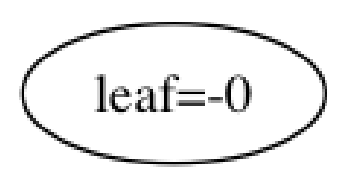

In [12]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [13]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

ValueError: Booster.get_score() results in empty

## Neural network

In [20]:
import tensorflow as tf
from tensorflow import keras

X, y = df[['total_corner','line','chl_low','odd_change','peak_change','corner_line_diff','seconds_since_start']], df[['is_low']]
dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
train_dataset = dataset.shuffle(len(df)).batch(1)


In [21]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_dataset, epochs=15)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/15
98/98 [==============================] - 1s 13ms/step - loss: nan - accuracy: 0.4898
Epoch 2/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 3/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 4/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 5/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 6/15
98/98 [==============